In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from tools_fast import *
from clustering import cluster, cluster_net
from hc_graph import *

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


In [3]:
fund_name = 'AQMIX'
pd.read_csv(r"financial_data/hfrx_index_names.csv", index_col=0)

### Financial data loads and cleaning

,Full Name
Name,
HFRXAR,HFRX Absolute Return Index
HFRXDS,HFRX ED: Distressed Restructuring Index
HFRXMA,HFRX ED: Merger Arbitrage Index
HFRXSS,HFRX ED: Special Situations Index
HFRXEMN,HFRX EH: Equity Market Neutral Index
HFRXEHG,HFRX EH: Fundamental Growth Index
HFRXEHV,HFRX EH: Fundamental Value Index
HFRXEMC,HFRX Emerging Markets Composite Index
HFRXEW,HFRX Equal Weighted Strategies Index


In [4]:
# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True)
hfrx = make_ER(hfrx_all[[fund_name]].dropna(), US_rate)

# BNP

bnp = pd.read_csv(r"financial_data/bnp_data_long_term.csv", index_col=0, parse_dates=True, dayfirst=True)

risk_premia = pd.read_pickle("financial_data/risk_premia_ER_FX_USD.pkl").drop('BPCURVW4', axis=1)


In [5]:
df_info = pd.read_csv(r"financial_data/bnp_info.csv", index_col=0)
df_info

,Asset Class,Style
Ticker,,
BNPIDRXA,Commodity,Carry
BNPIF3AX,Commodity,Carry
BNPIF3XM,Commodity,Momentum
BPFXSTGU,FX,Value
BNPICCE3,Equity,Carry
BNPIVMRU,Equity,Reversal
BPCURVW4,MM,Carry
BNPIVCXA,Commodity,Volatility
BNPIAIRT,Bonds,Volatility


In [6]:
prices_all = hfrx.join(bnp,how="left").join(risk_premia,how="left").ffill()
returns_all = prices_all.pct_change().iloc[1:]
hrfx_returns = returns_all[[fund_name]]
returns_all = returns_all.drop(fund_name, axis=1)
prices_all = prices_all.drop(fund_name, axis=1).bfill()

In [7]:
prices_futur = hfrx.join(bnp,how="left")
returns_fut = prices_futur.pct_change().iloc[1:]
hrfx_returns_fut = returns_fut[[fund_name]]
returns_fut = returns_fut.drop(fund_name, axis=1)
prices_futur = prices_futur.drop(fund_name, axis=1).bfill()

In [8]:
prices_risk_premia = hfrx.join(risk_premia,how="left").ffill()
returns_risk_premia = prices_risk_premia.pct_change().iloc[1:]
hrfx_returns_rp = returns_risk_premia[[fund_name]]
returns_risk_premia = returns_risk_premia.drop(fund_name, axis=1)
prices_risk_premia = prices_risk_premia.drop(fund_name, axis=1).bfill()

## Estimation of the exposures

In [9]:
size = 126
freq = 5
freq_ml = 20

### Volatility adjustment

In [10]:
tau = 0.1
tc = 0.0005
nu = 1.0
lag_fut = 2
lag_rp = 3
lag = max(lag_fut, lag_rp)
vol_period = 20


In [36]:
%%time
df_weight_kalman_aic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj = selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj = ml_selective_kalman_filter(hrfx_returns, returns_all,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj = kalman_filter(hrfx_returns, returns_all,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj, _ = ml_kalman_filter(hrfx_returns, returns_all, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_all.loc[df_weight_kalman_voladj.index[0]:]

replication_kalman_voladj = make_track(prices_for_track, df_weight_kalman_voladj, tc=tc, lag=lag)
df_res_voladj = hfrx.loc[replication_kalman_voladj.index]
df_res_voladj["Kalman VT"] = replication_kalman_voladj

replication_ml_kalman_voladj = make_track(prices_for_track, df_weight_ml_kalman_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman VT"] = replication_ml_kalman_voladj

prices_for_track = prices_all.loc[df_weight_kalman_aic_voladj.index[0]:]

replication_kalman_aic_voladj = make_track(prices_for_track, df_weight_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman AIC VT"] = replication_kalman_aic_voladj

replication_ml_kalman_aic_voladj = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj

replication_kalman_bic_voladj = make_track(prices_for_track, df_weight_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["Kalman BIC VT"] = replication_kalman_bic_voladj

replication_ml_kalman_bic_voladj = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj, tc=tc, lag=lag)
df_res_voladj["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj

Wall time: 1min 19s


In [38]:
%%time
df_weight_kalman_aic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_fut = selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_fut = ml_selective_kalman_filter(hrfx_returns_fut, returns_fut,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_fut = kalman_filter(hrfx_returns_fut, returns_fut,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_fut, _ = ml_kalman_filter(hrfx_returns_fut, returns_fut, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_futur.loc[df_weight_kalman_voladj_fut.index[0]:]

replication_kalman_voladj_fut = make_track(prices_for_track, df_weight_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut = hfrx.loc[replication_kalman_voladj_fut.index]
df_res_voladj_fut["Kalman VT"] = replication_kalman_voladj_fut

replication_ml_kalman_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman VT"] = replication_ml_kalman_voladj_fut

prices_for_track = prices_futur.loc[df_weight_kalman_aic_voladj_fut.index[0]:]

replication_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman AIC VT"] = replication_kalman_aic_voladj_fut

replication_ml_kalman_aic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_fut

replication_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["Kalman BIC VT"] = replication_kalman_bic_voladj_fut

replication_ml_kalman_bic_voladj_fut = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_fut, tc=tc, lag=lag_fut)
df_res_voladj_fut["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_fut

Wall time: 45.2 s


In [39]:
%%time
df_weight_kalman_aic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_bic_voladj_rp = selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq,\
                                          nu=nu, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_bic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='bic', vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_aic_voladj_rp = ml_selective_kalman_filter(hrfx_returns_rp, returns_risk_premia,sample_length=size, frequency=freq_ml,
                                                     tau=tau, criterion='aic', vol_target=True, vol_period=vol_period)
df_weight_kalman_voladj_rp = kalman_filter(hrfx_returns_rp, returns_risk_premia,freq, sigma_weight=1. , sigma_return=nu,
                                        vol_target=True, vol_period=vol_period)
df_weight_ml_kalman_voladj_rp, _ = ml_kalman_filter(hrfx_returns_rp, returns_risk_premia, freq_ml, tau=tau, vol_target=True, vol_period=vol_period)

prices_for_track = prices_risk_premia.loc[df_weight_kalman_voladj_rp.index[0]:]

replication_kalman_voladj_rp = make_track(prices_for_track, df_weight_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia = hfrx.loc[replication_kalman_voladj_rp.index]
df_res_voladj_risk_premia["Kalman VT"] = replication_kalman_voladj_rp

replication_ml_kalman_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman VT"] = replication_ml_kalman_voladj_rp

prices_for_track = prices_risk_premia.loc[df_weight_kalman_aic_voladj_rp.index[0]:]

replication_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman AIC VT"] = replication_kalman_aic_voladj_rp

replication_ml_kalman_aic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_aic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman AIC VT"] = replication_ml_kalman_aic_voladj_rp

replication_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["Kalman BIC VT"] = replication_kalman_bic_voladj_rp

replication_ml_kalman_bic_voladj_rp = make_track(prices_for_track, df_weight_ml_kalman_bic_voladj_rp, tc=tc, lag=lag_rp)
df_res_voladj_risk_premia["ML Kalman BIC VT"] = replication_ml_kalman_bic_voladj_rp

Wall time: 17.4 s


### All Factors

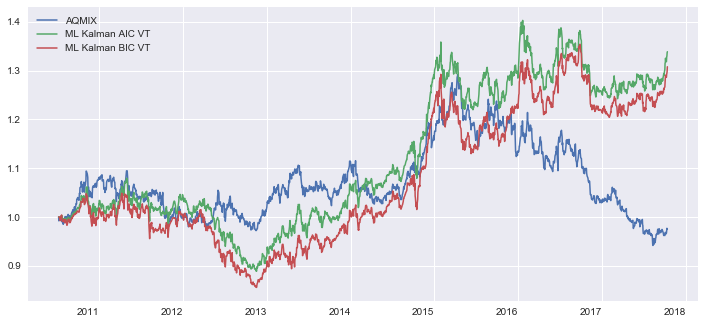

In [40]:
df_res_voladj = df_res_voladj.dropna().loc['2008':'2017-10-13']
df_res_voladj = (df_res_voladj / df_res_voladj.iloc[0])
df_res_voladj[[fund_name, 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj = df_res_voladj[[fund_name]].copy()
temp = df_res_voladj.drop(fund_name, axis=1)
df_res_volperfadj[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [41]:
df_stat_vol = replication_stats(df_res_voladj, fund_name=fund_name)
df_stat_vol

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
AQMIX,1.000000,1.000000,0.000000,1.000000,0.012760,-0.003208,-0.256981
Kalman VT,0.664403,0.495749,0.079268,0.289252,0.297378,0.024791,-0.222790
ML Kalman VT,0.661444,0.469029,0.076174,0.343654,0.448403,0.037231,-0.152167
Kalman AIC VT,0.643938,0.477349,0.081306,0.252230,0.455797,0.040711,-0.215606
ML Kalman AIC VT,0.641133,0.488936,0.079772,0.280185,0.461650,0.039753,-0.169314
Kalman BIC VT,0.598716,0.426142,0.085407,0.174886,0.521010,0.046587,-0.176267
ML Kalman BIC VT,0.597874,0.457246,0.084005,0.201759,0.426369,0.035966,-0.178728


### Classic Factors

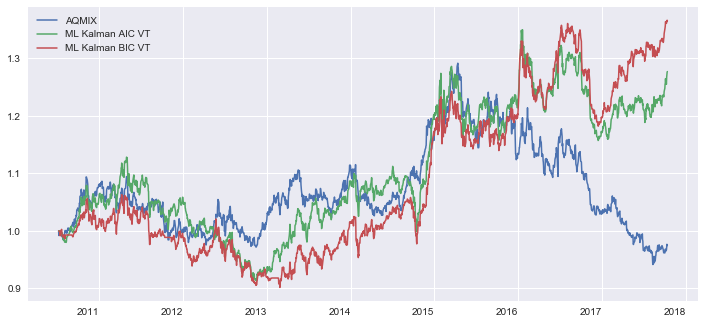

In [42]:
df_res_voladj_fut = df_res_voladj_fut.dropna().loc['2008':'2017-10-13']
df_res_voladj_fut = (df_res_voladj_fut / df_res_voladj_fut.iloc[0])
df_res_voladj_fut[[fund_name, 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj_fut = df_res_voladj_fut[[fund_name]].copy()
temp = df_res_voladj_fut.drop(fund_name, axis=1)
df_res_volperfadj_fut[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [43]:
df_stat_vol_fut = replication_stats(df_res_voladj_fut, fund_name=fund_name)
df_stat_vol_fut

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
AQMIX,1.000000,1.000000,0.000000,1.000000,0.012760,-0.003208,-0.256981
Kalman VT,0.603576,0.430610,0.087146,0.140949,0.348714,0.030529,-0.219283
ML Kalman VT,0.582211,0.415002,0.087555,0.132873,0.525358,0.047380,-0.170614
Kalman AIC VT,0.578372,0.399590,0.088031,0.123406,0.253395,0.020108,-0.230479
ML Kalman AIC VT,0.601022,0.413466,0.085115,0.180530,0.390012,0.033434,-0.183527
Kalman BIC VT,0.511441,0.366050,0.096948,-0.063179,0.379949,0.033935,-0.208693
ML Kalman BIC VT,0.560386,0.400612,0.089173,0.100512,0.493241,0.043604,-0.142696


### Risk Premia

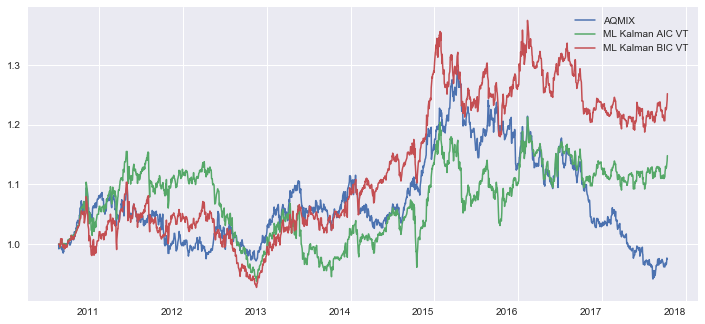

In [44]:
df_res_voladj_risk_premia = df_res_voladj_risk_premia.dropna().loc['2008':'2017-10-13']
df_res_voladj_risk_premia = (df_res_voladj_risk_premia / df_res_voladj_risk_premia.iloc[0])
df_res_voladj_risk_premia[[fund_name, 'ML Kalman AIC VT', 'ML Kalman BIC VT']].plot(figsize=(12,6), rot=0, linewidth=1.5)
df_res_volperfadj_risk_premia = df_res_voladj_risk_premia[[fund_name]].copy()
temp = df_res_voladj_risk_premia.drop(fund_name, axis=1)
df_res_volperfadj_risk_premia[temp.columns]= make_ER(temp, 2 + 0 * US_rate)

In [45]:
df_stat_vol_risk_premia = replication_stats(df_res_voladj_risk_premia, fund_name=fund_name)
df_stat_vol_risk_premia

,Correlation,Kendall tau,Tracking error,R-squared,Sharpe ratio,Annual Return,Maximum Drawdown
AQMIX,1.000000,1.000000,0.000000,1.000000,0.012760,-0.003208,-0.256981
Kalman VT,0.593726,0.475897,0.091907,0.044514,0.308829,0.027799,-0.215858
ML Kalman VT,0.534459,0.382167,0.091905,0.044558,-0.006003,-0.005207,-0.314260
Kalman AIC VT,0.597882,0.454370,0.090123,0.081264,0.280183,0.024227,-0.196719
ML Kalman AIC VT,0.602589,0.478438,0.088280,0.118447,0.222073,0.017672,-0.182750
Kalman BIC VT,0.602814,0.457833,0.088889,0.106239,0.360362,0.032583,-0.207733
ML Kalman BIC VT,0.610857,0.469085,0.083995,0.201948,0.349506,0.029365,-0.150183


## Volatility Contributions

In [46]:
df_weight_kalman_voladj_ = df_weight_kalman_voladj.loc['2008':'2017-10-13']
df_vol_contrib_kalman_voladj = (prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).std()
df_vol_contrib_kalman_voladj = df_vol_contrib_kalman_voladj/df_vol_contrib_kalman_voladj.sum()

df_weight_ml_kalman_bic_voladj_ = df_weight_ml_kalman_bic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_bic_voladj = (prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).std()
df_vol_contrib_ml_kalman_bic_voladj = df_vol_contrib_ml_kalman_bic_voladj/df_vol_contrib_ml_kalman_bic_voladj.sum()

df_weight_ml_kalman_aic_voladj_ = df_weight_ml_kalman_aic_voladj.loc['2008':'2017-10-13']
df_vol_contrib_ml_kalman_aic_voladj = (prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).std()
df_vol_contrib_ml_kalman_aic_voladj = df_vol_contrib_ml_kalman_aic_voladj/df_vol_contrib_ml_kalman_aic_voladj.sum()

In [47]:
vol_contrib = pd.DataFrame()
# vol_contrib['Kalman'] = df_vol_contrib_kalman_voladj
vol_contrib["ML Kalman AIC VT"] = df_vol_contrib_ml_kalman_aic_voladj
vol_contrib["ML Kalman BIC VT"] = df_vol_contrib_ml_kalman_bic_voladj
vol_contrib = vol_contrib.join(df_info).reset_index()

In [48]:
vol_contrib_asset_class = vol_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
vol_contrib_style = vol_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [49]:
repli = "ML Kalman BIC VT"
g = hc_piechart(vol_contrib_asset_class[[repli]], title="Vol contribution by Asset Class in " + repli)
g.plot()

In [50]:
g = hc_piechart(vol_contrib_style[[repli]], title="Vol contribution by Style in " + repli)
g.plot()

## Performance contributions

In [51]:
perf_contrib_kalman_voladj = (1 + prices_all.reindex(df_weight_kalman_voladj_.index).pct_change()*df_weight_kalman_voladj_).prod() - 1
perf_contrib_ml_kalman_bic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_bic_voladj_.index).pct_change()*df_weight_ml_kalman_bic_voladj_).prod() - 1
perf_contrib_ml_kalman_aic_voladj = (1 + prices_all.reindex(df_weight_ml_kalman_aic_voladj_.index).pct_change()*df_weight_ml_kalman_aic_voladj_).prod() - 1

In [52]:
perf_contrib = pd.DataFrame()
# perf_contrib["Kalman"] = perf_contrib_kalman_voladj
perf_contrib["ML Kalman AIC VT"] = perf_contrib_ml_kalman_aic_voladj
perf_contrib["ML Kalman BIC VT"] = perf_contrib_ml_kalman_bic_voladj
perf_contrib = perf_contrib.join(df_info).reset_index()

In [53]:
perf_contrib_asset_class = perf_contrib.drop(["Style"],axis=1).groupby(["Asset Class","index"]).sum()
perf_contrib_style = perf_contrib.drop(["Asset Class"],axis=1).groupby(["Style","index"]).sum()

In [54]:
g = hc_spiderweb(perf_contrib_asset_class, title="Performance contribution by Asset Class")
g.plot()

In [55]:
g = hc_spiderweb(perf_contrib_style, title="Performance contribution by Style")
g.plot()

## plt charts

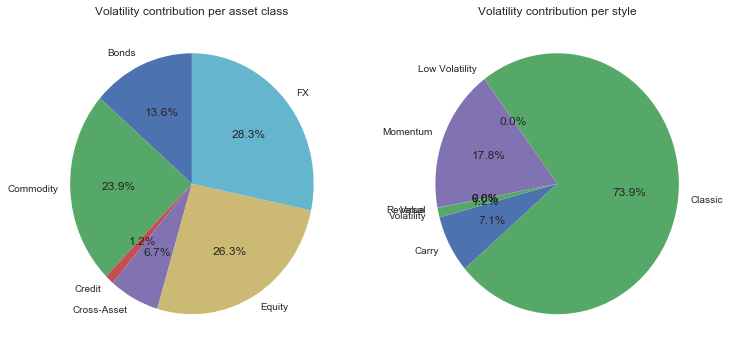

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
vol_contrib_asset_class.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax1,
                                              title='Volatility contribution per asset class', startangle=90)
ax1.set_ylabel('')
vol_contrib_style.groupby(level=0).sum().plot(kind='pie', y=repli, legend=False, autopct='%1.1f%%', ax=ax2,
                                              title='Volatility contribution per style', startangle=195)
_ = ax2.set_ylabel('')

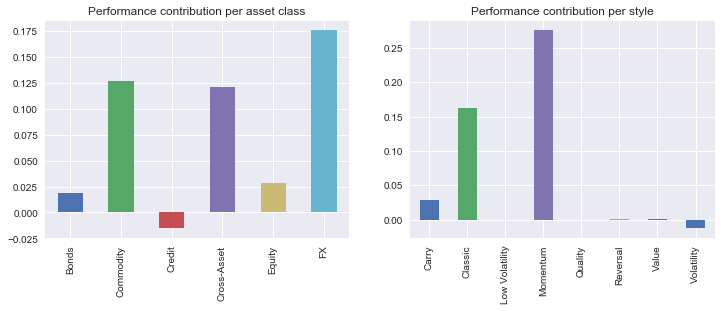

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,4))
perf_contrib_asset_class[repli].groupby(level=0).sum().plot(kind='bar', ax=ax1,
                                                     title='Performance contribution per asset class')
ax1.set_xlabel('')
perf_contrib_style[repli].groupby(level=0).sum().plot(kind='bar', ax=ax2,
                                                     title='Performance contribution per style')
_ = ax2.set_xlabel('')